In [1]:
import scipy.linalg
import scipy.optimize
import sys
import numpy as np
import importlib
import matplotlib.pyplot as plt
import scripts.theodolite_function as tfu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import scripts.theodolite_utils as ttfu


def R_z(theta):
    R = np.eye(4,4)
    R[0,:2] = [np.cos(theta), -np.sin(theta)]
    R[1,:2] = [np.sin(theta), np.cos(theta)]
    return R

def T_z(theta, t):
    T = R_z(theta)
    T[:3,3] = t
    return T
    
def dist(p,q):
    return np.linalg.norm(p-q)

def plot_theodolite(ax, T, c1='tab:red', c2='tab:green', name=""):
    b = T@np.array([0,0,0,1])
    dx = T@np.array([1,0,0,1]) - b
    dy = T@np.array([0,1,0,1]) - b
    
    plt.arrow(*b[:2], *dx[:2], color=c1)
    plt.arrow(*b[:2], *dy[:2], color=c2)
    plt.text(*b[:2],name)
    
d_truth = 1
#equilateral triangle
prisms = np.array([[0,0,0,1], [d_truth,0,0,1], R_z(np.pi/3.)@np.array([1,0,0,1])])
center = np.mean(prisms, 0)
center[3]=0

for i in range(len(prisms)):
    prisms[i] -= center
    prisms[i] -= np.array([5,0,0,0])
    

#def traj circle
N=6
def gen_points(N):
    p1s = np.zeros((4,N))
    p2s = np.zeros((4,N))
    p3s = np.zeros((4,N))

    for i in range(N):
        T = T_z(float(i)/N*2*np.pi, np.array([8,0,0]))
        p1s[:,i] = T@prisms[0]
        p2s[:,i] = T@prisms[1]
        p3s[:,i] = T@prisms[2]

    #put theodolites
    # T1 = T_z(0,[-3,0,0])
    # T2 = T_z(-np.pi/3.,[0,2,0])
    # T3 = T_z(np.pi/3.,[0,-5,0])
    T1 = T_z(0,[0,0,0])
    T2 = T_z(0,[-2,5,0])
    T3 = T_z(np.pi/3.,[0,-5,0])

    #points in local ref 
    p1s_l = np.zeros((N,4))
    p2s_l = np.zeros((N,4))
    p3s_l = np.zeros((N,4))
    for i in range(N):
        T = T_z(float(i)/N*2*np.pi, np.array([8,0,0]))
        p1s_l[i] = np.linalg.inv(T1)@T@prisms[0]
        p2s_l[i] = np.linalg.inv(T2)@T@prisms[1]
        p3s_l[i] = np.linalg.inv(T3)@T@prisms[2]

    #get GT T12 and T13
    T12 = np.linalg.inv(T1) @ T2
    T13 = np.linalg.inv(T1) @ T3
    
    return T1, T2, T3, T12, T13, p1s, p2s, p3s, p1s_l, p2s_l, p3s_l

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


<IPython.core.display.Javascript object>


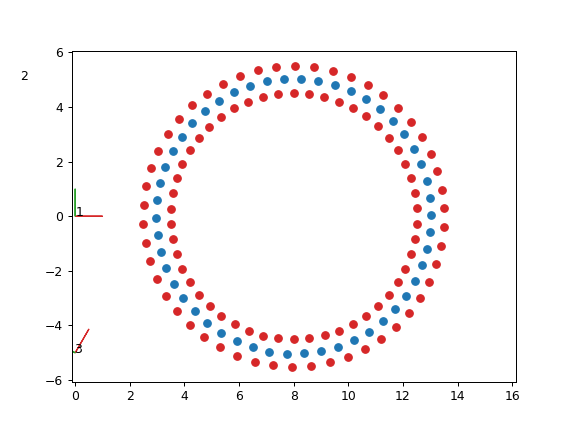

In [2]:
%matplotlib notebook

T1, T2, T3, T12, T13, p1s, p2s, p3s, p1s_l, p2s_l, p3s_l = gen_points(50)

plt.figure()
plt.axis('equal')
ax = plt.gca()

plot_theodolite(ax,T1, name="1")
plot_theodolite(ax,T2, name="2")
plot_theodolite(ax,T3, name="3")

plt.scatter(p1s[0,:], p1s[1,:], color='tab:red')
plt.scatter(p2s[0,:], p2s[1,:], color='tab:red')
plt.scatter(p3s[0,:], p3s[1,:], color='tab:blue')
plt.show()

In [3]:
%matplotlib notebook

def cost_fun(p1s_l, p2s_l, p3s_l, xi_12, xi_13):
    T12 = exp_T(xi_12)
    T13 = exp_T(xi_13)
    c=0
    c += sum([(dist(p1,T12@p2)-d_truth)**2 for p1,p2 in zip(p1s_l, p2s_l)])
    c += sum([(dist(p1,T13@p3)-d_truth)**2 for p1,p3 in zip(p1s_l, p3s_l)])
    c += sum([(dist(T12@p2,T13@p3)-d_truth)**2 for p2,p3 in zip(p2s_l, p3s_l)])
    
    return c

def vee(xi):
    T = np.zeros((4,4))
    T[:3,:3] = np.array([[ 0,     -xi[2], xi[1]],
                        [ xi[2], 0,     -xi[0]],
                        [-xi[1], xi[0], 0]])
    T[:3,3] = xi[3:]
    return T
    
def exp_T(xi):
    return scipy.linalg.expm(vee(xi))

f = lambda x: cost_fun(p1s_l, p2s_l, p3s_l, x[:6], x[6:])

res = scipy.optimize.minimize(lambda x: cost_fun(p1s_l, p2s_l, p3s_l, x[:6], x[6:]), 
                             x0=np.zeros((12,1)))

xi_12 = res.x[:6]
xi_13 = res.x[6:] 
T12 = exp_T(xi_12)
T13 = exp_T(xi_13)

#plt.figure()
#plt.axis('equal')
#ax = plt.gca()

#plot_theodolite(ax,np.eye(4,4), name="1")
#plot_theodolite(ax,T12, name="2")
#plot_theodolite(ax,T13, name="3")
#plt.show()

In [4]:
import time
from tqdm import tqdm as tqdm

its = []
times = []
Ns = range(0,150,10)

for N in tqdm(Ns):
    T1, T2, T3, T12, T13, p1s, p2s, p3s, p1s_l, p2s_l, p3s_l = gen_points(N)
    f = lambda x: cost_fun(p1s_l, p2s_l, p3s_l, x[:6], x[6:])
    
    start = time.time()
    res = scipy.optimize.minimize(lambda x: cost_fun(p1s_l, p2s_l, p3s_l, x[:6], x[6:]), 
                                 x0=np.zeros((12,1)))
    end = time.time()
    
    its += [res.nit]
    times += [end - start]


plt.figure()
plt.plot(Ns, times)
plt.xlabel("number of poses")
plt.ylabel("computation time [s]")


 27%|██▋       | 4/15 [00:04<00:13,  1.25s/it]


KeyboardInterrupt: 

Text(0, 0.5, 'number of iterations')

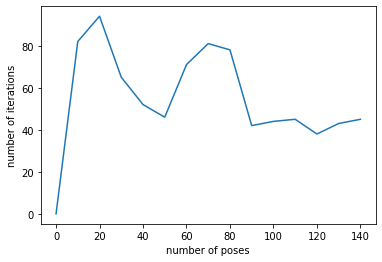

In [4]:
plt.figure()
plt.plot(Ns, its)

plt.xlabel("number of poses")
plt.ylabel("number of iterations")

In [5]:
%matplotlib notebook
ttfu = importlib.reload(ttfu)
path = "./data/raw_data/20220312/GP-10-20_"

trimble_1 = ttfu.read_prediction_data_resection_csv_file(path+"1.csv")
trimble_2 = ttfu.read_prediction_data_resection_csv_file(path+"2.csv")
trimble_3 = ttfu.read_prediction_data_resection_csv_file(path+"3.csv")

In [6]:
p1s_l = np.array(trimble_1)[:,1:5]
p2s_l = np.array(trimble_2)[:,1:5]
p3s_l = np.array(trimble_3)[:,1:5]
print(p1s_l)

[[21.96580381 -0.58831684  0.61164646  1.        ]
 [21.96579348 -0.58832257  0.61165961  1.        ]
 [21.96583071 -0.58830919  0.61164802  1.        ]
 ...
 [11.9901767   0.51923608  0.57967692  1.        ]
 [11.99019381  0.5192943   0.57967057  1.        ]
 [11.98999036  0.51934238  0.57964642  1.        ]]


In [7]:
def cost_fun(p1s_l, p2s_l, p3s_l, xi_12, xi_13, d_truth12, d_truth13, d_truth23):
    T12 = exp_T(xi_12)
    T13 = exp_T(xi_13)
    c=0
    c += sum([(dist(p1,T12@p2)-d_truth12)**2 for p1,p2 in zip(p1s_l, p2s_l)])
    c += sum([(dist(p1,T13@p3)-d_truth13)**2 for p1,p3 in zip(p1s_l, p3s_l)])
    c += sum([(dist(T12@p2,T13@p3)-d_truth23)**2 for p2,p3 in zip(p2s_l, p3s_l)])
    
    return c

def vee(xi):
    T = np.zeros((4,4))
    T[:3,:3] = np.array([[ 0,     -xi[2], xi[1]],
                        [ xi[2], 0,     -xi[0]],
                        [-xi[1], xi[0], 0]])
    T[:3,3] = xi[3:]
    return T
    
def exp_T(xi):
    return scipy.linalg.expm(vee(xi))


In [8]:
# 12 03 2022
Dist_prism_12 = 0.8860734460339026
Dist_prism_13 = 0.8303896290142598
Dist_prism_23 = 1.0393117663247973

f = lambda x: cost_fun(p1s_l, p2s_l, p3s_l, x[:6], x[6:], Dist_prism_12, Dist_prism_13, Dist_prism_23)

res = scipy.optimize.minimize(lambda x: cost_fun(p1s_l, p2s_l, p3s_l, x[:6], x[6:], Dist_prism_12, Dist_prism_13, Dist_prism_23), 
                             x0=np.zeros((12,1)))

xi_12 = res.x[:6]
xi_13 = res.x[6:] 
T12 = exp_T(xi_12)
T13 = exp_T(xi_13)

In [31]:
p1s_r = p1s_l
p2s_r = T12@p2s_l.T
p3s_r = T13@p3s_l.T

print(T12)
print(T13)

T12c = np.array([[-1.14787566e-01, -9.93390061e-01,  2.35772209e-05, -1.20117897e+00],
 [ 9.93390056e-01, -1.14787568e-01, -1.00038546e-04, -8.54266131e-03],
 [ 1.02083670e-04,  1.19381956e-05,  9.99999995e-01,  2.95658635e-01],
 [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
T13c = np.array([[-1.85621128e-01, -9.82621372e-01,  1.92696549e-04, -2.68548334e+00],
 [ 9.82621284e-01, -1.85621196e-01, -4.29790186e-04, -3.01140148e-01],
 [ 4.58089586e-04,  1.09569591e-04,  9.99999889e-01,  4.54447040e-01],
 [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
print(T12c)
print(T13c)

[[-1.14898069e-01 -9.93376400e-01 -1.32727789e-03 -1.21492442e+00]
 [ 9.93270819e-01 -1.14905214e-01  1.44869756e-02  5.40067442e-04]
 [-1.45435308e-02  3.46179127e-04  9.99894177e-01  1.08582136e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-1.85719045e-01 -9.82594071e-01  4.16264369e-03 -2.71024344e+00]
 [ 9.82252381e-01 -1.85764274e-01 -2.59209398e-02 -3.39887785e-01]
 [ 2.62430323e-02 -7.25245519e-04  9.99655329e-01  1.23874059e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-1.14787566e-01 -9.93390061e-01  2.35772209e-05 -1.20117897e+00]
 [ 9.93390056e-01 -1.14787568e-01 -1.00038546e-04 -8.54266131e-03]
 [ 1.02083670e-04  1.19381956e-05  9.99999995e-01  2.95658635e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-1.85621128e-01 -9.82621372e-01  1.92696549e-04 -2.68548334e+00]
 [ 9.82621284e-01 -1.85621196e-01 -4.29790186e-04 -3.01140148e-01]
 [ 4.58089586e-04  1.09569591e-04  9.99999889e-01  4.544470

<IPython.core.display.Javascript object>


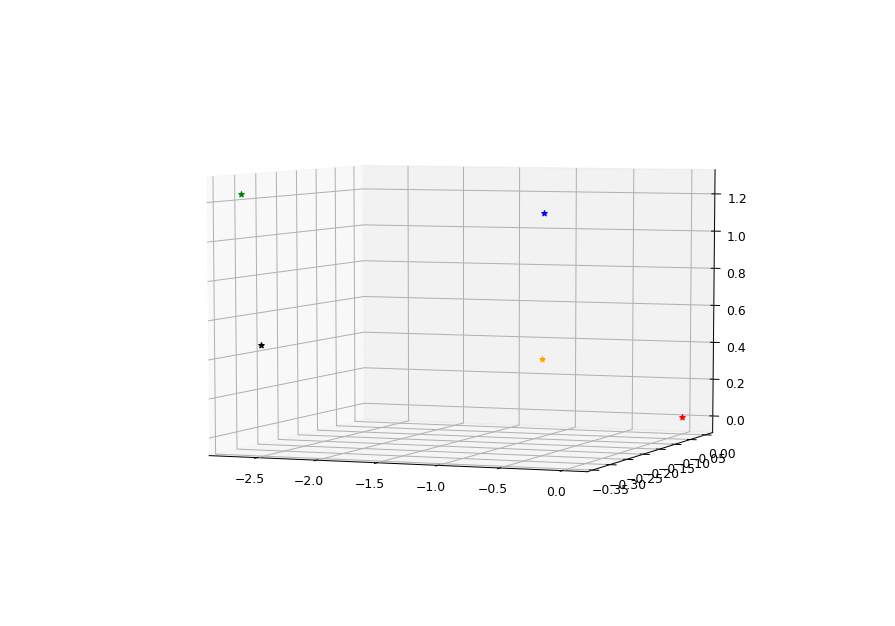

/home/norlab/python-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


In [32]:
%matplotlib notebook
fig = plt.figure(figsize=(10,7))
ax = plt.gca()
ax = plt.axes(projection ="3d")
ax.scatter3D(0, 0, 0, c='red', marker='*', label="Theodolite 1")
ax.scatter3D(T12[0,3], T12[1,3], T12[2,3], c='blue', marker='*', label="Theodolite 2")
ax.scatter3D(T13[0,3], T13[1,3], T13[2,3], c='green', marker='*', label="Theodolite 3")
ax.scatter3D(T12c[0,3], T12c[1,3], T12c[2,3], c='orange', marker='*', label="Theodolite 2")
ax.scatter3D(T13c[0,3], T13c[1,3], T13c[2,3], c='black', marker='*', label="Theodolite 3")
plt.show()

<IPython.core.display.Javascript object>


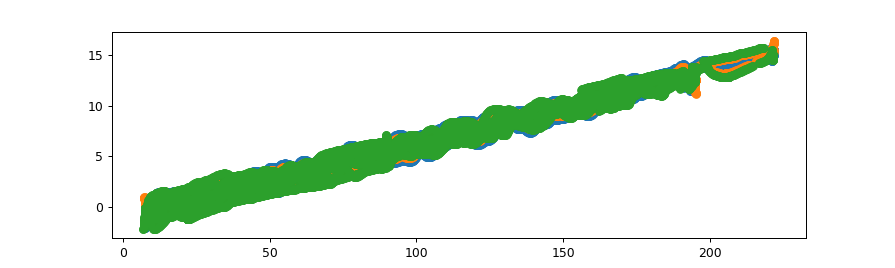

In [16]:
%matplotlib notebook

p2s_rarr = np.array(p2s_r).T
p3s_rarr = np.array(p3s_r).T

plt.figure(figsize=(10,3))
plt.scatter(p1s_r[:,0],p1s_r[:,1])
plt.scatter(p2s_rarr[:,0],p2s_rarr[:,1])
plt.scatter(p3s_rarr[:,0],p3s_rarr[:,1])
plt.show()

<IPython.core.display.Javascript object>


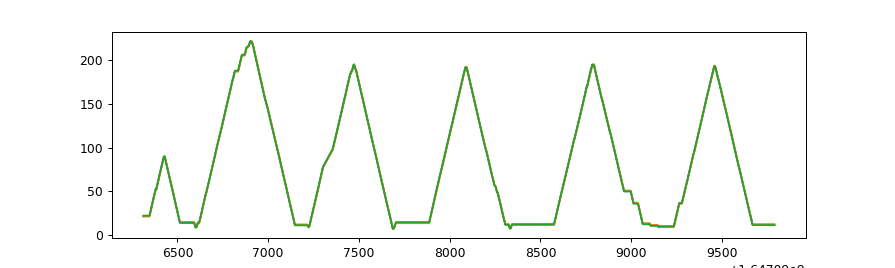

In [33]:
plt.figure(figsize=(10,3))
plt.plot(np.array(trimble_1)[:,0],p1s_r[:,0])
plt.plot(np.array(trimble_1)[:,0],p2s_rarr[:,0])
plt.plot(np.array(trimble_1)[:,0],p3s_rarr[:,0])
plt.show()

<IPython.core.display.Javascript object>


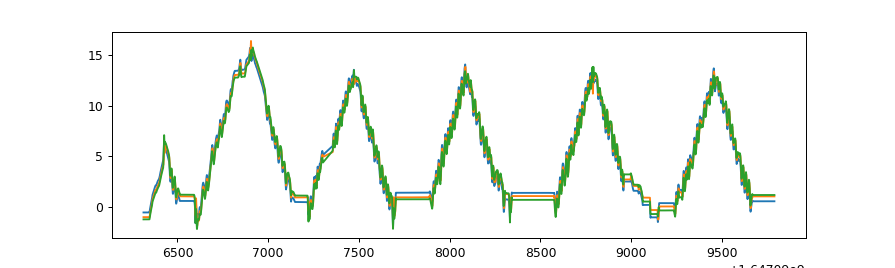

In [34]:
plt.figure(figsize=(10,3))
plt.plot(np.array(trimble_1)[:,0],p1s_r[:,1])
plt.plot(np.array(trimble_1)[:,0],p2s_rarr[:,1])
plt.plot(np.array(trimble_1)[:,0],p3s_rarr[:,1])
plt.show()

<IPython.core.display.Javascript object>


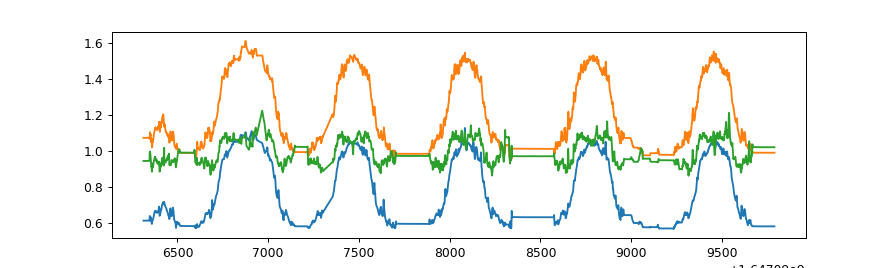

In [35]:
plt.figure(figsize=(10,3))
plt.plot(np.array(trimble_1)[:,0],p1s_r[:,2])
plt.plot(np.array(trimble_1)[:,0],p2s_rarr[:,2])
plt.plot(np.array(trimble_1)[:,0],p3s_rarr[:,2])
plt.show()

In [45]:
dist_prism = []
timestamp = np.array(trimble_1)[:,0]
for i in range(0,len(timestamp)-1):
    dp1 = abs(np.linalg.norm(p1s_r[i,0:3]-p2s_rarr[i,0:3])-Dist_prism_12)*1000
    dp2 = abs(np.linalg.norm(p1s_r[i,0:3]-p3s_rarr[i,0:3])-Dist_prism_13)*1000
    dp3 = abs(np.linalg.norm(p3s_rarr[i,0:3]-p2s_rarr[i,0:3])-Dist_prism_23)*1000
    dist_prism.append(np.array([timestamp[i], dp1, dp2, dp3]))
dist_prism = np.array(dist_prism)

Mean inter-prism [mm]:  20.95 45.89 46.29
Std inter-prism [mm]:  26.14 36.82 96.07


<IPython.core.display.Javascript object>


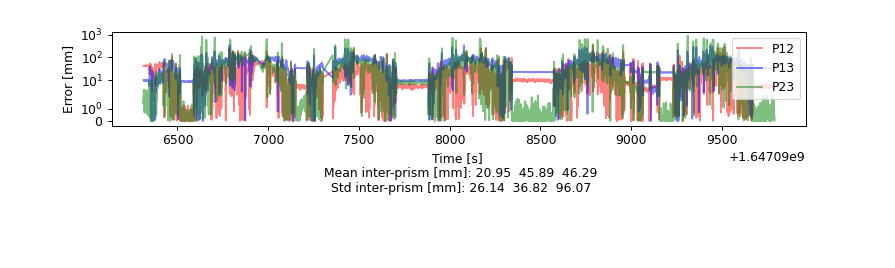

In [49]:
print("Mean inter-prism [mm]: ", round(np.mean(dist_prism[:,1]),2), round(np.mean(dist_prism[:,2]),2), round(np.mean(dist_prism[:,3]),2))
print("Std inter-prism [mm]: ", round(np.std(dist_prism[:,1]),2), round(np.std(dist_prism[:,2]),2), round(np.std(dist_prism[:,3]),3))
plt.figure(figsize=(10,3))
plt.subplot(211)
plt.plot(dist_prism[:,0], dist_prism[:,1], label="P12", color="red", alpha=0.5)
plt.plot(dist_prism[:,0], dist_prism[:,2], label="P13", color="blue", alpha=0.5)
plt.plot(dist_prism[:,0], dist_prism[:,3], label="P23", color="green", alpha=0.5)
ax = plt.gca()
ax.set_yscale('symlog')
plt.legend(loc='best')
ax.set_ylabel("Error [mm]")
ax.set_xlabel("Time [s] \n Mean inter-prism [mm]: " + str(round(np.mean(dist_prism[:,1]),2)) + "  " + str(round(np.mean(dist_prism[:,2]),2)) + "  " + str(round(np.mean(dist_prism[:,3]),2))
             + "\n Std inter-prism [mm]: " + str(round(np.std(dist_prism[:,1]),2)) + "  " + str(round(np.std(dist_prism[:,2]),2)) + "  " + str(round(np.std(dist_prism[:,3]),2)))
plt.savefig("./figs/20220312_new_resection.jpg")
plt.show()  